$$
\newcommand{\dd}{\text{d}}
\newcommand{\pdv}[2]{ \frac{\partial #1}{\partial #2}  }
\newcommand{\dv}[2]{ \frac{\dd #1}{\dd #2} }
$$

# Parametric modal expansion

__THIS NOTEBOOK:__ Call out to functions in external scripts to make all plots for conditional averaging

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.io as sio
from scipy.signal import welch
from scipy import sparse, linalg
from scipy.interpolate import interp1d, UnivariateSpline

from numpy.fft import fft, ifft, fftshift, fftfreq
import numpy.random as rng

import sympy

import matplotlib as mpl
from matplotlib import rcParams
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
from matplotlib.colors import ListedColormap
cm = sns.diverging_palette(250, 20, s=90, l=35, n=16)
cm = ListedColormap(cm)

# Custom packages
import meanfield
import utils
import lindy

# Load data

In [2]:
data = sio.loadmat('data/wake_expt.mat')
Uinf = data['Uinf'][0, 0]  # Freestream velocity (m/s)
Pinf = data['Pinf'][0, 0]  # Freestream dynamic pressure, based on rho_air = 1.2041 (20C)
D = 1e-3*data['D'][0, 0]   # Diameter of the body (m)
fs = data['fs'][0, 0]      # Sampling rate (Hz)
dt = 1/fs

# Sensor locations
rESP = data['r_sensor'][0]  # Nondimensionalized by D
thetaESP = data['theta_sensor'][0]
theta_plot = np.array([*thetaESP, thetaESP[0]])  # Include dummy location for plotting
nr, nth = len(rESP), len(thetaESP)
dr = rESP[1]-rESP[0]

# Actual data
P = data['P']  # Already nondimensionalized by Pinf
P = np.reshape(P, (nr, nth, -1), order='F')    # azimuthal x radius
m = fftfreq(P.shape[0], d=1/P.shape[0])  # Azimuthal wavenumbers

# Unsteady aerodynamic center of pressure
cop = data['CoP']  # [radial, azimuthal]

### Order parameter

Defined as integrated $m=1$ Fourier component (unsteady aerodynamic center of pressure)

In [3]:
A = cop[0, :]*np.exp(-1j*cop[1, :])  # Complex amplitude of CoP

# Rescale A to be order 1 based on mean value
A_avg = np.mean(abs(A))
A = A/A_avg

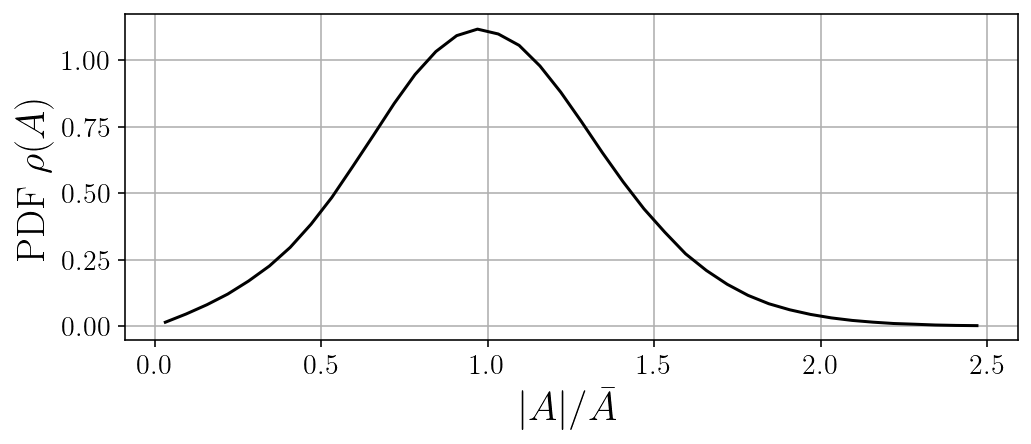

In [4]:
nbins = 40
A_edges = np.linspace(0, 2.5, nbins+1)
A_centers = 0.5*(A_edges[:-1]+A_edges[1:])
pA_hist = np.histogram(abs(A), bins=A_edges, density=True)[0]

plt.figure(figsize=(8, 3))
plt.plot(A_centers, pA_hist, c='k')
plt.xlabel(r"$|A| / \bar{A}$")
plt.ylabel(r"PDF $\rho(A)$")
plt.grid()

# Phase aligned conditional average

In [5]:
# Phase align
q = meanfield.phase_align(P, A)

# Compute conditional mean
#    qd ~ mean field deformation
qd, qd_err = meanfield.cond_avg(q, A, A_edges)

# Unconditional mean
q_avg = np.mean(q, axis=2)
qB = qd[:, :, 0]          # First bin ~ smallest amplitude
qd = qd - qB[:, :, None]  # Remove base flow component
# Fixed mode (difference between conditional mean and symmetric base)
q_fixed = q_avg - qB

# Expand in Fourier space
qd_hat = fft(qd, axis=1, norm='ortho')
qd_err_hat = fft(qd_err, axis=1, norm='ortho')  # uncertainty in average
qf_hat = fft(q_fixed, axis=1, norm='ortho')

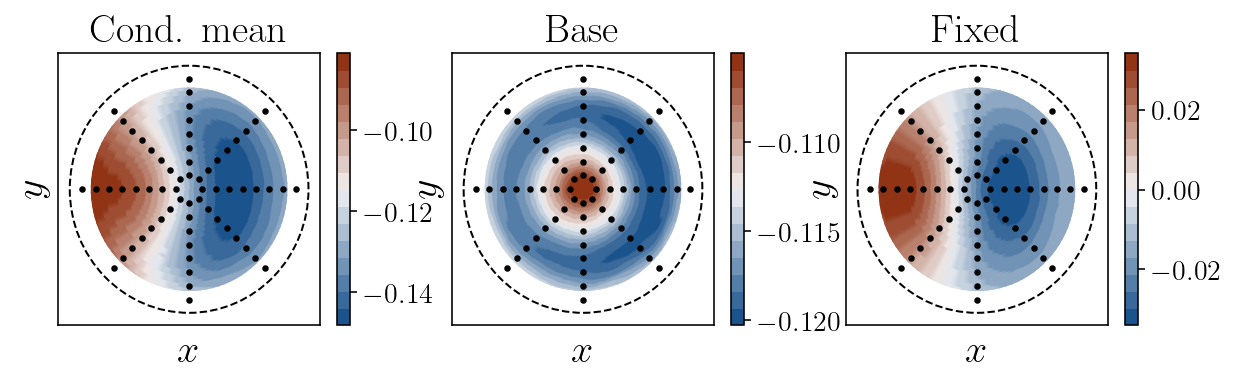

In [6]:
# Plot mean, base, and fixed 'shift' modes (all axisymmetric)

plt.figure(figsize=(10, 2.5))
plt.subplot(131)
meanfield.plot(q_avg, cm=cm)
plt.xlabel(r'$x$')
plt.ylabel('$y$')
plt.title('Cond. mean')

plt.subplot(132)
meanfield.plot(qB, cm=cm)
plt.xlabel(r'$x$')
plt.ylabel('$y$')
plt.title('Base')

plt.subplot(133)
k = 2  # Mode index to plot
meanfield.plot(q_fixed, cm=cm)
plt.xlabel(r'$x$')
plt.ylabel('$y$')
plt.title('Fixed')

plt.show()

# Parametric modes from conditional average

### Show scaling 

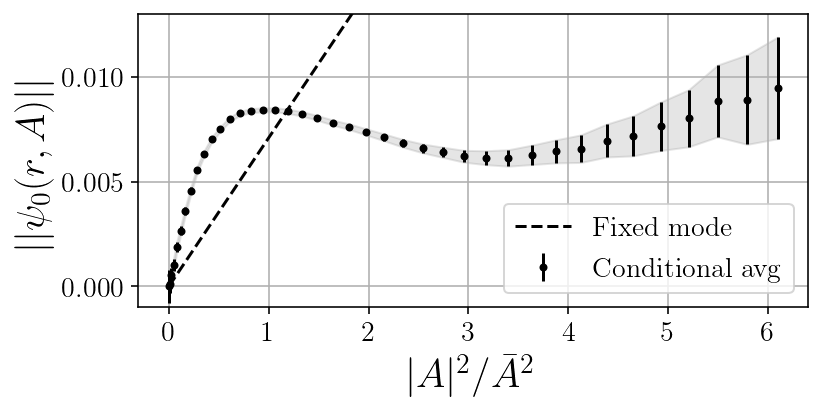

In [7]:
# Plot energy vs |A|^2 along with fixed mode approximation

k = 0  # Wavenumber index

# Integrated energy
Ed = np.real( [ meanfield.ip(qd_hat[:, k, i], qd_hat[:, k, i])
               for i in range(nbins)] )
Ed_err = np.sqrt( np.mean(abs(qd_err_hat[:, k, :])**2, axis=0) ) # Error in radial direction

# Fixed mode energy
Ef = A_centers**4 * np.real( meanfield.ip(qf_hat[:, k], qf_hat[:, k]) )

plt.figure(figsize=(6, 2.7))
plt.errorbar(A_centers**2, np.sqrt(Ed), yerr=Ed_err, fmt='k.', label='Conditional avg')
plt.fill_between(A_centers**2,
                 np.sqrt(Ed)-Ed_err,
                 np.sqrt(Ed)+Ed_err,
                 color='gray', alpha=0.2)

plt.plot(A_centers**2, np.sqrt(Ef), 'k--', label='Fixed mode')

plt.legend(fontsize=14)
plt.ylim([-1e-3, 1.3e-2])
plt.grid()

plt.ylabel(r"$|| \psi_0(r, A) ||$")
plt.xlabel(r"$|A|^2 / \bar{A}^2$")

plt.show()

Repeat for $m=1, 2$

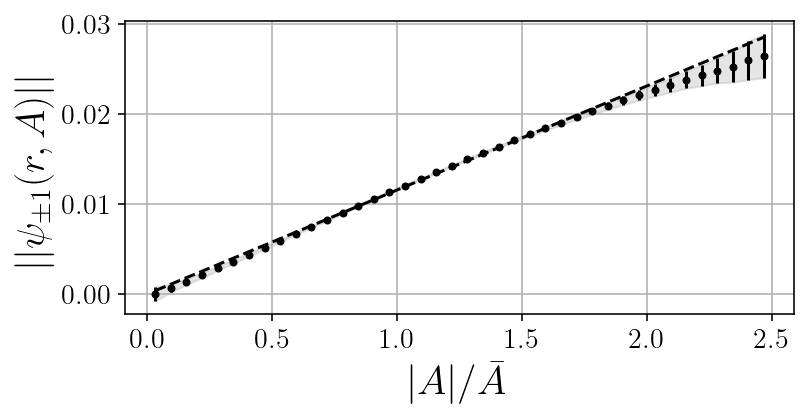

In [8]:
# Integrated energy
k = 1

Ed = np.real( [ meanfield.ip(qd_hat[:, k, i], qd_hat[:, k, i]) for i in range(nbins)] )   # Deformation energy
Ef = np.real( A_centers**2 * meanfield.ip(qf_hat[:, k], qf_hat[:, k]) )   # Fixed mode energy

plt.figure(figsize=(6, 2.7))

plt.errorbar(A_centers, np.sqrt(Ed), yerr=Ed_err,
             fmt='k.', label='Conditional avg')
plt.plot(A_centers, np.sqrt(Ef), 'k--', label='Fixed mode')

plt.fill_between(A_centers,
                 np.sqrt(Ed)-Ed_err,
                 np.sqrt(Ed)+Ed_err,
                 color='gray', alpha=0.2)

#plt.legend(fontsize=14)
#plt.ylim([-0.1, 0.05])
plt.grid()


plt.ylabel(r"$|| \psi_{\pm 1}(r, A) ||$")
plt.xlabel(r"$|A| / \bar{A}$")

plt.show()

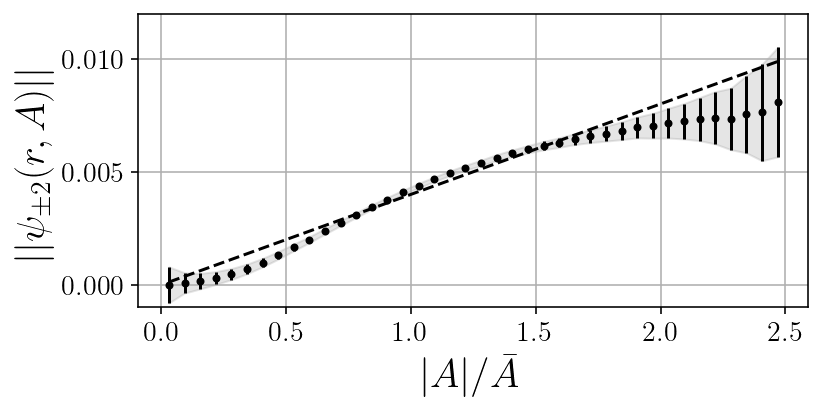

In [9]:
# Integrated energy
k = 2

Ed = np.real( [ meanfield.ip(qd_hat[:, k, i], qd_hat[:, k, i]) for i in range(nbins)] )   # Deformation energy
Ef = np.real( A_centers**2 * meanfield.ip(qf_hat[:, k], qf_hat[:, k]) )   # Shift mode energy

plt.figure(figsize=(6, 2.7))

plt.errorbar(A_centers, np.sqrt(Ed), yerr=Ed_err,
             fmt='k.', label='Conditional avg')
plt.plot(A_centers, np.sqrt(Ef), 'k--', label='Fixed mode')

plt.fill_between(A_centers,
                 np.sqrt(Ed)-Ed_err,
                 np.sqrt(Ed)+Ed_err,
                 color='gray', alpha=0.2)

#plt.legend(fontsize=14)
plt.ylim([-1e-3, 1.2e-2])
plt.grid()


plt.ylabel(r"$|| \psi_{\pm 2}(r, A) ||$")
plt.xlabel(r"$|A| / \bar{A}$")

plt.show()

### Define parametric modal expansion

In [10]:
qB0 = np.real( fft(qB, axis=1, norm='ortho')[:, 0] )   # Symmetric part of base flow
qd0 = np.real(qd_hat[:, 0, :])   # m=0
qd0_err = np.real(qd_err_hat[:, 0, :])
qd1 = qf_hat[:, 1]      # m=1
qd2 = qd_hat[:, 2, :]   # m=2

# Simple linear interpolation for m=2 deformation
qd2_interp = [interp1d(A_centers, qd2[i, :].T, kind='linear', fill_value='extrapolate') for i in range(nr)]

# Estimates amplitude at each radial sensor location
qd2_fn = lambda A: np.array([qd2_interp[i](A) for i in range(nr)])

# Fit with spline for m=0 (need to take derivative later)
fit_idx = np.nonzero(A_centers < 2.5)[0]
qd0_spl = [UnivariateSpline(A_centers[fit_idx]**2, qd0[i, fit_idx], k=2, w=1/qd0_err[i, fit_idx]) for i in range(nr)]
qd0_fn = lambda A: np.array([qd0_spl[i](abs(A)**2) for i in range(nr)])

qd0_spl_deriv = [qd0_spl[i].derivative() for i in range(nr)]
qd0_grad = lambda A: np.array([qd0_spl_deriv[i](abs(A)**2) for i in range(nr)])  # psiB in the paper

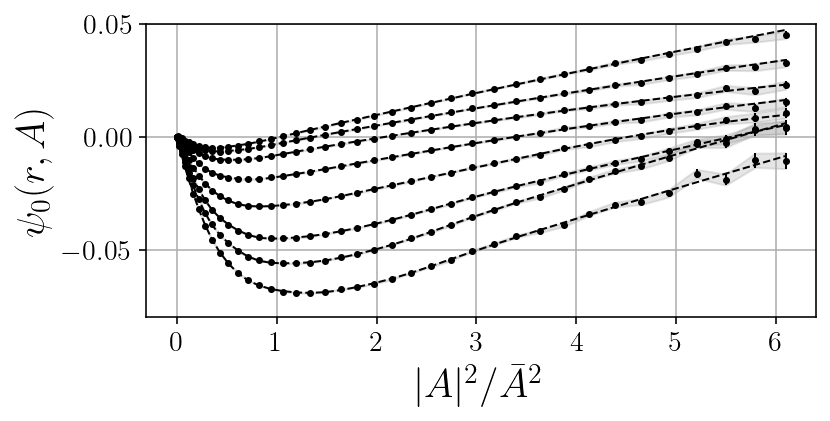

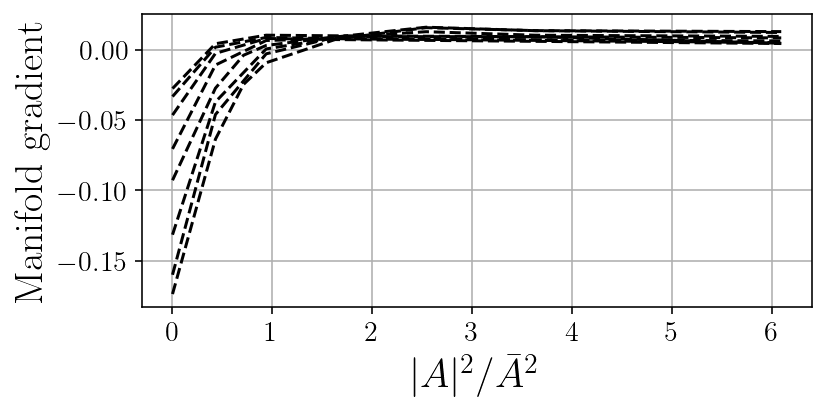

In [11]:

plt.figure(figsize=(6, 2.7))

#plt.plot(A_centers**2, np.real(qd_hat[:, 0, :]).T, 'k-', markersize=5, lw=1)
plt.plot(A_centers**2, qd0_fn(A_centers).T, 'k--', lw=1)
for i in range(nr):
    plt.errorbar(A_centers**2, np.real(qd_hat[i, 0, :]).T, yerr=np.real(qd_err_hat[i, 0, :]),
                 fmt='k.', lw=1, markersize=5)
    plt.fill_between(A_centers**2,
                     np.real(qd_hat[i, 0, :])-np.real(qd_err_hat[i, 0, :]),
                     np.real(qd_hat[i, 0, :])+np.real(qd_err_hat[i, 0, :]),
                    color='gray', alpha=0.2)

#plt.legend(["$r={{{0:0.2f}}}$".format(r) for r in rESP], fontsize=14)
plt.xlabel(r"$|A|^2 / \bar{A}^2$")
plt.ylabel(r"$\psi_0(r, A)$")
plt.ylim([-0.08, 0.05])
#plt.xlim([0, 2.0])
plt.grid()
plt.show()

plt.figure(figsize=(6, 2.7))
plt.plot(A_centers**2, qd0_grad(A_centers).T, 'k--')

#plt.legend(["$r={{{0:0.2f}}}$".format(r) for r in rESP], fontsize=14)
plt.xlabel(r"$|A|^2/\bar{A}^2$")
plt.ylabel("Manifold gradient")
#plt.ylim([-.2, .1])
plt.grid()
plt.show()


### Residual projection for mean flow modification

In [12]:
# Extract m=0 component
q0 = np.real( fft(P, axis=1, norm='ortho')[:, 0, :] )  

# Interpolated approximation on manifold
qA = qB0[:, None] + qd0_fn(A)

# Fluctuations from manifold approximation (qT ~ q' = turbulent)
qT = q0 - qA

In [13]:
# Residual projection

# Mass matrix
w   = (rESP*dr)
W   = np.diag(w**0.5)  # Sqrt of mass matrix
W_inv = np.linalg.inv(W)

X = W @ (2*abs(A)*qd0_grad(A))   # Evaluate gradient at the time-varying value of A
Y = W @ qT

B = np.array([ (X[:, i].T @ Y[:, i])/(X[:, i].T @ X[:, i]) for i in range(len(A)) ])

### Reconstruction

In [14]:
def reconstruct(A, B):
    # Complex CoP amplitude A
    q_hat = np.zeros((nr, nth, len(A)), dtype=np.complex64)
    q_hat[:, 0, :] = qB0[:, None] + qd0_fn(A)  # m=0 deformation
    q_hat[:, 0, :] += 2*abs(A)*B*qd0_grad(A)            # Linearized manifold
    
    q_hat[:,  1, :] = np.outer(qd1, A)
    q_hat[:, -1, :] = np.outer(np.conj(qd1), A.conj())
    
    phase = A/abs(A)  # exp(i*phi)
    q_hat[:,  2, :] = qd2_fn(abs(A)) * phase**2
    q_hat[:, -2, :] = qd2_fn(abs(A)).conj() / phase**2
    
    return np.real(ifft(q_hat, axis=1, norm='ortho'))

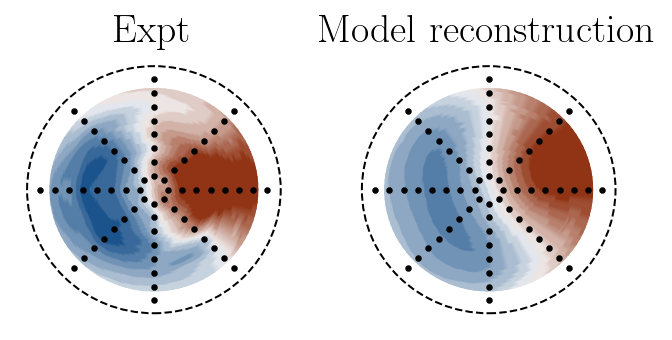

In [15]:
# Try recostruction
t_idx = 920

field = P[:, :, t_idx]

# Mean field reconstruction
reconstructed_field = reconstruct(A[[t_idx]], B[t_idx])

plt.figure(figsize=(5.5,2.5))
clim = [-0.18, -0.05]
plt.subplot(121)
meanfield.plot(field, vmin=clim[0], vmax=clim[1], colorbar=False, cm=cm)
plt.title(r'Expt')
plt.gca().axis('off')

plt.subplot(122)
meanfield.plot(reconstructed_field, vmin=clim[0], vmax=clim[1], colorbar=False, cm=cm)
plt.title(r'Model reconstruction')
plt.gca().axis('off')

plt.subplots_adjust(wspace=0.2)
plt.show()

Reconstruct symmetric part of the field... this shows the importance of the extra degree of freedom "B"

In [16]:
q_delta = 2*abs(A)*B*qd0_grad(A)
qC = qA + q_delta

# Mass matrix
w   = (rESP*dr)
W   = np.diag(w**0.5)  # Sqrt of mass matrix
W_inv = np.linalg.inv(W)

E0 = np.array( [(W @ q0[:, i]) @ (W @ q0[:, i]) for i in range(len(A)) ] )
EA = np.array( [(W @ qA[:, i]) @ (W @ qA[:, i]) for i in range(len(A)) ] )
EC = np.array( [(W @ qC[:, i]) @ (W @ qC[:, i]) for i in range(len(B)) ] )

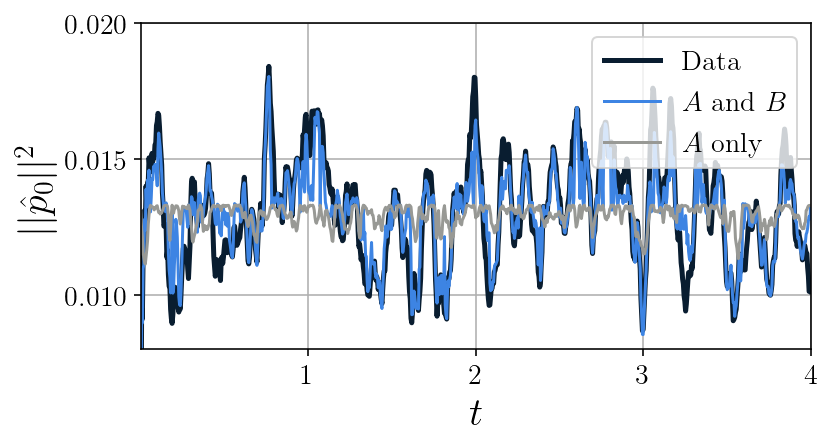

In [17]:
colors = ["#091d30", "#989995", "#3d84e3", "#3c2d80"]


plt.figure(figsize=(6, 3))
nplt = int(2e3)
plt.plot(dt*np.arange(nplt), E0[:nplt], c=colors[0], lw=2.5, label='Data')
plt.plot(dt*np.arange(nplt), EC[:nplt], c=colors[2], lw=1.5, label='$A$ and $B$')
plt.plot(dt*np.arange(nplt), EA[:nplt], c=colors[1], lw=1.5, label='$A$ only')
plt.legend(fontsize=14, loc=1)
plt.xlim([0.001, 4])
plt.ylim([0.008, 0.02])
plt.gca().set_yticks([0.01, 0.015, 0.02])
plt.xlabel('$t$')
plt.ylabel(r'$||\hat{p}_0||^2$')

plt.grid()

Reconstruct full time series

In [18]:
# Error of parametric mean field expansion
P_est = reconstruct(A, B)
err_interp = meanfield.err_full(P, P_est)

Power spectral density by Fourier component

In [19]:
Phat = fft(P, axis=1, norm='ortho')
Phat_est = fft(P_est, axis=1, norm='ortho')

# Welch PSD estimate
freq, psd = welch(Phat, fs, nperseg=2**14, axis=2, window='hanning', return_onesided=False)
_, psd_est = welch(Phat_est, fs, nperseg=2**14, axis=2, window='hanning', return_onesided=False)

freq = freq[:len(freq)//2]
psd = psd[:, :, :len(freq)]
psd_est = psd_est[:, :, :len(freq)]

# Strouhal number (dimensionless frequency)
St = freq*D/Uinf

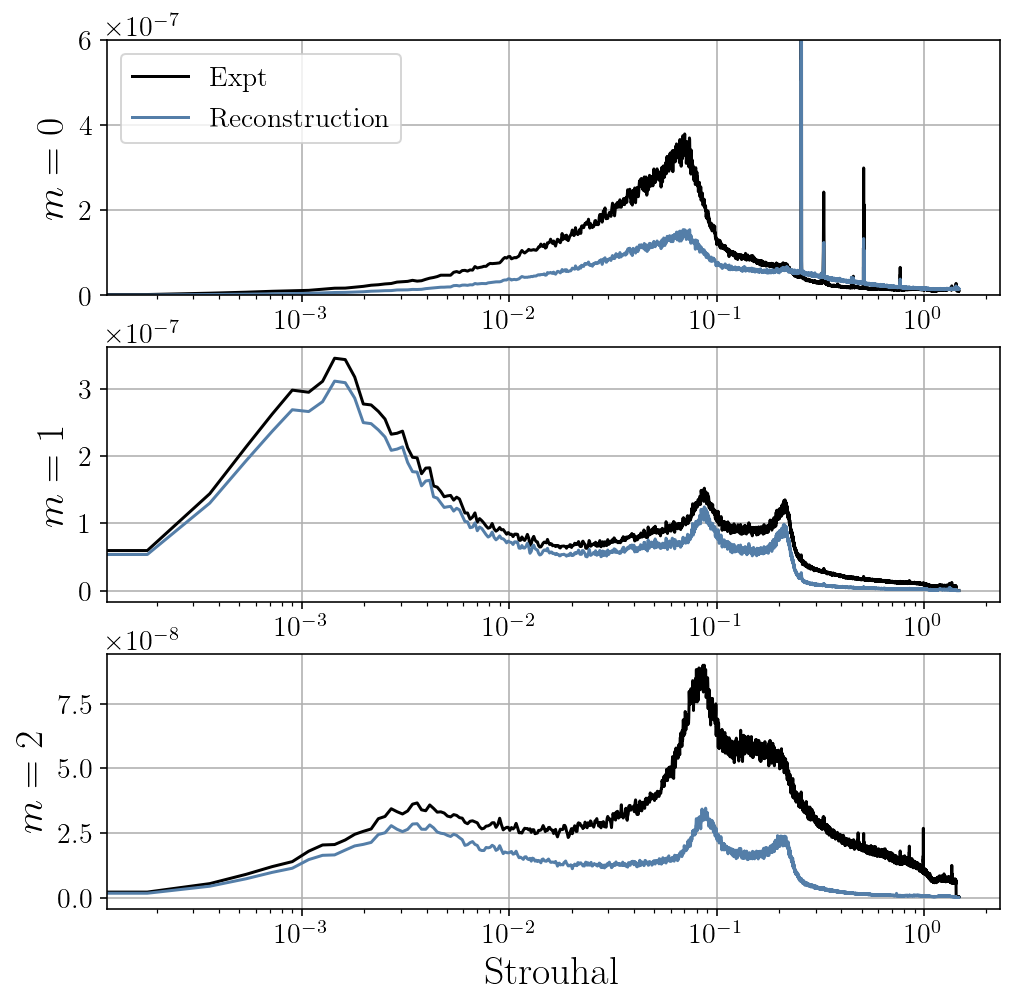

In [20]:
# Integrate each wavenumber in radial direection
plt.figure(figsize=(8, 8))
for k in [0, 1, 2]:
    plt.subplot(3, 1, k+1)
    
    psd_avg = np.trapz( rESP * psd[:, k, :].T, dx=dr, axis=1)
    plt.semilogx(St, St*psd_avg, c='k')
    
    psd_avg = np.trapz( rESP * psd_est[:, k, :].T, dx=dr, axis=1)
    plt.semilogx(St, St*psd_avg, c=cm(2))
    
    if k==0:
        plt.legend(["Expt", "Reconstruction"], fontsize=14)
        plt.ylim([0, 6e-7])
            
    plt.grid()
    plt.ylabel('$m={{{0}}}$'.format(k))
    
plt.xlabel('Strouhal')
plt.show()

Save time series of order parameters

In [49]:
sio.savemat('data/order_parameters.mat', {"A": A, "B": B})

# Langevin regression

In [52]:
A_model = lindy.A_model(A, lag=200)
Xi_A, _ = A_model.fit(kl_reg=1e-2)

KL Regularization: 0.01
%%%% Optimization time: 221.51228284835815 seconds,   Cost: 0.0006886937468528369 %%%%


In [53]:
Xi_A

array([ 1.94664237+0.15653969j, -1.86153858-0.02116783j,
        0.79667144+0.6952434j ,  0.27283408+0.35327874j])

In [118]:
B_model = lindy.B_model(B, lag=40)
Xi_B, _ = B_model.fit(kl_reg=1e2)
Xi_B

KL Regularization: 100.0
%%%% Optimization time: 0.3833737373352051 seconds,   Cost: 0.030284055458126413 %%%%


array([-24.03291441,   6.70211019,   0.20292594])

In [98]:
# Construct closures for drift and diffusion functions
Xi_fA = Xi_A[:len(A_model.f_expr)]
Xi_sA = Xi_A[len(A_model.f_expr):]

Xi_fB = Xi_B[:len(B_model.f_expr)]
Xi_sB = Xi_B[len(B_model.f_expr):]

z = sympy.symbols('z')
fA = sympy.lambdify(z, utils.sindy_model(Xi_fA, A_model.f_expr))
sA = sympy.lambdify(z, utils.sindy_model(Xi_sA, A_model.s_expr))
fB = sympy.lambdify(z, utils.sindy_model(Xi_fB, B_model.f_expr))
sB = sympy.lambdify(z, utils.sindy_model(Xi_sB, B_model.s_expr))

### Monte Carlo simulation

In [102]:
# Monte Carlo validation against pdf
# Time step with Euler-Maruyama
nsteps = int(4e6)  # How many steps to save

# Time-step with Euler-Maruyama method
A_MC = np.zeros(nsteps, dtype=np.complex64)
A_MC[0] = 1
B_MC = np.zeros(nsteps)
for i in range(nsteps-1):  # Outer loop: save state
    
    if i%(nsteps//10) == 0: print(i)
        
    ### Update A
    w = np.real(sA(A_MC[i]))*rng.randn() + 1j*np.imag(sA(A_MC[i]))*rng.randn() # Wiener increment
    A_MC[i+1] = A_MC[i] + fA(A_MC[i])*dt + np.sqrt(dt)*w  # Euler-Maruyama update
    
    ### Update B
    w = sB(B_MC[i])*rng.randn()
    B_MC[i+1] = B_MC[i] + fB(B_MC[i])*dt + np.sqrt(dt)*w
    
    if np.isnan(A_MC[i+1]) or np.isnan(B_MC[i+1]):
        print("Solution blew up at time t={0}".format(i*dt))
        break

0
400000
800000
1200000
1600000
2000000
2400000
2800000
3200000
3600000


In [103]:
sio.savemat('data/monte_carlo.mat', {"A": A_MC, "B": B_MC})

# Reconstruct from Monte Carlo

In [21]:
MC_data = sio.loadmat('data/monte_carlo.mat')
A_MC = MC_data['A'][0]
B_MC = MC_data['B'][0]

In [22]:
P_MC = reconstruct(A_MC, B_MC)

Power spectral density by Fourier component

In [23]:
Phat_MC = fft(P_MC, axis=1, norm='ortho')

# Welch PSD estimate
freq_MC, psd_MC = welch(Phat_MC, fs, nperseg=2**13, axis=2, window='hanning', return_onesided=False)

freq_MC = freq_MC[:len(freq_MC)//2]
psd_MC = psd_MC[:, :, :len(freq_MC)]
St_MC = freq_MC*D/Uinf

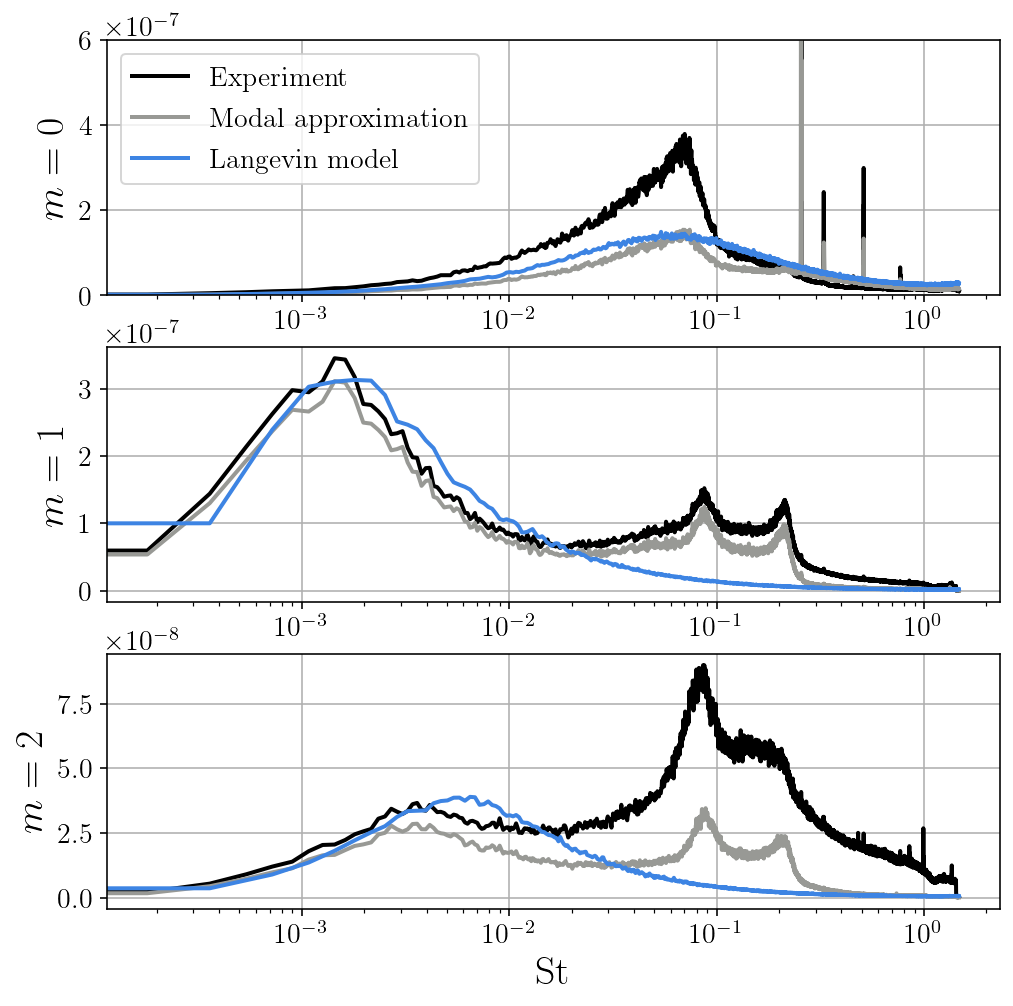

In [24]:
# Average in radial direction
plt.figure(figsize=(8, 8))
for k in [0, 1, 2]:
    plt.subplot(3, 1, k+1)
    
    psd_avg = np.trapz( rESP * psd[:, k, :].T, dx=dr, axis=1)
    plt.semilogx(St, St*psd_avg, c='k', lw=2)
    
    psd_avg = np.trapz( rESP * psd_est[:, k, :].T, dx=dr, axis=1)
    plt.semilogx(St, St*psd_avg, c=colors[1], lw=2)
    if k==0:
        plt.ylim([0, 6e-7])
        
    psd_avg = np.trapz( rESP * psd_MC[:, k, :].T, dx=dr, axis=1)
    plt.semilogx(St_MC, St_MC*psd_avg, c=colors[2], lw=2)
        
    if k==0:
        plt.legend(["Experiment", "Modal approximation", "Langevin model"], fontsize=14)
        
#     if k==2:
#         plt.gca().set_yticks([0, 2e-8, 2e-8, 4e-8, 6e-8, 8e-8])
        
    plt.grid()
    plt.ylabel('$m={{{0}}}$'.format(k))
    
plt.xlabel('St')
plt.show()

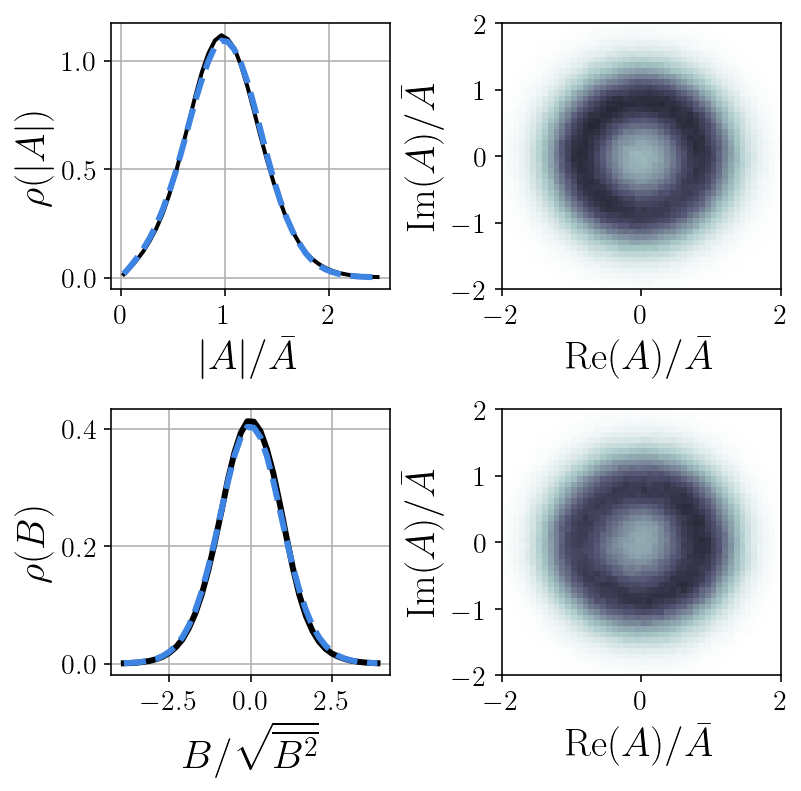

In [25]:
plt.figure(figsize=(6, 6))

plt.subplot(221)
nbins = 40
edges = np.linspace(0, 2.5, nbins+1)
centers = 0.5*(edges[:-1]+edges[1:])

p_hist = np.histogram(abs(A), bins=edges, density=True)[0]
p_est = np.histogram(abs(A_MC), bins=edges, density=True)[0]

plt.plot(centers, p_hist, c='k', lw=2, label="Expt")
plt.plot([], [])
plt.plot(centers, p_est, c=colors[2], lw=3, ls='--', label="Langevin")
plt.xlabel(r"$|A|/\bar{A}$")
plt.ylabel(r"$\rho(|A|)$")
plt.grid()

plt.subplot(223)
edges = np.linspace(-4, 4, nbins+1)
centers = 0.5*(edges[:-1]+edges[1:])

p_hist = np.histogram(B, bins=edges, density=True)[0]
p_est = np.histogram(B_MC, bins=edges, density=True)[0]

plt.plot(centers, p_hist, c='k', lw=3, label="Expt")
plt.plot([], [])
plt.plot(centers, p_est, c=colors[2], lw=3, ls='--', label="Langevin")
plt.xlabel(r"$B/\sqrt{\overline{B^2}}$")
plt.ylabel(r"$\rho(B)$")
plt.grid()

# 2D histogram
N = 48
x_bins = np.linspace(-2, 2, N+1)
y_bins = np.linspace(-2, 2, N+1)
x_centers = 0.5*(x_bins[1:] + x_bins[:-1])
y_centers = 0.5*(y_bins[1:] + y_bins[:-1])
p_hist, _, _ = np.histogram2d(np.real(A), np.imag(A), bins=[x_bins, y_bins], density=True)
p_MC, _, _ = np.histogram2d(np.real(A_MC), np.imag(A_MC), bins=[x_bins, y_bins], density=True)

plt.subplot(222)
plt.pcolor(x_bins, y_bins, p_hist.T, cmap='bone_r', vmin=0, vmax=0.25)
plt.xlabel(r"$\mathrm{Re}(A)/\bar{A}$")
plt.ylabel(r"$\mathrm{Im}(A)/\bar{A}$")

plt.subplot(224)
plt.pcolor(x_bins, y_bins, p_MC.T, cmap='bone_r', vmin=0, vmax=0.25)
plt.xlabel(r"$\mathrm{Re}(A)/\bar{A}$")
plt.ylabel(r"$\mathrm{Im}(A)/\bar{A}$")

plt.subplots_adjust(hspace=0.45, wspace=0.4)
plt.show()